In [1]:
import numpy as np
import pandas as pd
import sparse
from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing
from sklearn.metrics import roc_curve, auc, matthews_corrcoef, f1_score, accuracy_score, roc_auc_score, make_scorer, average_precision_score, recall_score, confusion_matrix, precision_recall_curve
from math import sqrt
import numpy as np
import sys
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import random
import time
from datetime import datetime
import warnings
import model_metrics_helper

warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
pd.options.display.float_format = '{:,.4f}'.format

### Load Data

In [2]:
main_df = pd.read_csv("/gpfs/data/paulab/bvg228/sepsis_real_time_prediction/data/NYU_6hr_preprocessed_48hr_main_df_20220526_100348.csv")
id_sepsis = np.load("/gpfs/data/paulab/bvg228/sepsis_real_time_prediction/data/sepsis_48_20220526_100348.npy")
id_nosepsis = np.load("/gpfs/data/paulab/bvg228/sepsis_real_time_prediction/data/control_resampled_48_20220526_100348.npy")
sepsis_label_df = pd.read_csv('/gpfs/data/paulab/sepsis_floor_prediction/sepsis_real_time_prediction/preprocessed_data/sepsis_label_data_20220525_150654.csv', usecols=['ID', 't_timezero'])

predefined_mrns=True #this is optional. We've been using the same predefined train/val and test set in all of our experiments. 
train_val_mrns = pd.read_csv('/gpfs/data/paulab/sepsis_floor_prediction/sepsis_real_time_prediction/train_test_split_mrns/train_val_set_mrns_20220527_071248.csv')
test_mrns = pd.read_csv('/gpfs/data/paulab/sepsis_floor_prediction/sepsis_real_time_prediction/train_test_split_mrns/test_set_mrns_20220527_071248.csv')

### Add SIRS and Shift Sepsis Labels 

In [3]:
#add SIRS as a feature
main_df.rename(columns={'WHITE BLOOD CELL COUNT':'WBC', 'Systolic_BP':'SBP', 'GCS_Score':'gcs_total_score'}, inplace=True)
SIRS = model_metrics_helper.SIRS(main_df)
main_df = main_df.merge(SIRS, on = ['ID', 'rel_time'], how = "left")
main_df["SIRS"] = main_df["SIRS"] >= 2
main_df['SIRS'] = main_df['SIRS'].astype(int)

In [4]:
#shift sepsis labels
def shift_labels(main_df, lead_time_hr):

    main_df.loc[main_df['ShiftedSepsisLabel'].shift(-lead_time_hr) == 1,'ShiftedSepsisLabel'] = main_df['ShiftedSepsisLabel'].shift(-lead_time_hr)
    
    return main_df

main_df['SepsisLabel'] = main_df['SepsisLabel'].astype(int)
main_df['ShiftedSepsisLabel'] = main_df['SepsisLabel']
main_df = main_df.groupby('ID').apply(shift_labels, lead_time_hr=2)
main_df['ShiftedSepsisLabel'] = main_df['ShiftedSepsisLabel'].astype(int)
del main_df['SepsisLabel']

### Train Model

In [5]:
save_path = '/gpfs/data/paulab/sepsis_floor_prediction/sepsis_real_time_prediction'
outcome = 'Sepsis'
n_iters = 100
train_pc = 0.8
test_pc = 0.2

------------------------------------------------------------
Basic Cohort Information
------------------------------------------------------------
Splitting cohort into train and test set, train_pc: 80.0%; test_pc: 20.0%
Splitting cohort into train/val and test set using predefined mrns..
len(train_mrns): 404,000
len(test_mrns): 101,081
X_train.shape: (404000, 184)
X_test.shape: (101081, 184)
Y_train.shape: (404000,)
Y_test.shape: (101081,)
Shape of train/val set combined: (404000, 184); shape of test set (101081, 184)
There are 36640 Sepsis labels and 367360 no Sepsis labels in the train/val set
There are 2432 Sepsis cases and 24540 no Sepsis cases in the train/val set
There are 9517 Sepsis labels and 91564 no Sepsis labels and in the test set
There are 633 Sepsis cases and 6110 no Sepsis cases in the test set
------------------------------------------------------------
Model is Training for 100 Bootstraps to Predict Sepsis
------------------------------------------------------------



XGBoost Classifier 27/100
AUC Train: 0.966, Accuracy Train: 0.950, F1 Train: 0.680, MCC Train: 0.664
AUC Validation: 0.964, Accuracy Validation: 0.950, F1 Validation: 0.677, MCC Validation: 0.661
AUC Test: 0.963, Accuracy Test: 0.947, F1 Test: 0.679, MCC Test: 0.659

XGBoost Classifier 28/100
AUC Train: 0.966, Accuracy Train: 0.950, F1 Train: 0.676, MCC Train: 0.661
AUC Validation: 0.965, Accuracy Validation: 0.950, F1 Validation: 0.676, MCC Validation: 0.660
AUC Test: 0.963, Accuracy Test: 0.946, F1 Test: 0.674, MCC Test: 0.654

XGBoost Classifier 29/100
AUC Train: 0.966, Accuracy Train: 0.950, F1 Train: 0.678, MCC Train: 0.663
AUC Validation: 0.965, Accuracy Validation: 0.949, F1 Validation: 0.670, MCC Validation: 0.654
AUC Test: 0.963, Accuracy Test: 0.947, F1 Test: 0.675, MCC Test: 0.655

XGBoost Classifier 30/100
AUC Train: 0.966, Accuracy Train: 0.950, F1 Train: 0.679, MCC Train: 0.663
AUC Validation: 0.965, Accuracy Validation: 0.949, F1 Validation: 0.675, MCC Validation: 0.658


XGBoost Classifier 58/100
AUC Train: 0.966, Accuracy Train: 0.950, F1 Train: 0.679, MCC Train: 0.664
AUC Validation: 0.965, Accuracy Validation: 0.949, F1 Validation: 0.669, MCC Validation: 0.654
AUC Test: 0.963, Accuracy Test: 0.947, F1 Test: 0.674, MCC Test: 0.655

XGBoost Classifier 59/100
AUC Train: 0.966, Accuracy Train: 0.951, F1 Train: 0.682, MCC Train: 0.667
AUC Validation: 0.965, Accuracy Validation: 0.948, F1 Validation: 0.667, MCC Validation: 0.652
AUC Test: 0.963, Accuracy Test: 0.947, F1 Test: 0.675, MCC Test: 0.655

XGBoost Classifier 60/100
AUC Train: 0.966, Accuracy Train: 0.949, F1 Train: 0.676, MCC Train: 0.660
AUC Validation: 0.964, Accuracy Validation: 0.949, F1 Validation: 0.671, MCC Validation: 0.656
AUC Test: 0.963, Accuracy Test: 0.946, F1 Test: 0.675, MCC Test: 0.654

XGBoost Classifier 61/100
AUC Train: 0.966, Accuracy Train: 0.951, F1 Train: 0.682, MCC Train: 0.667
AUC Validation: 0.964, Accuracy Validation: 0.948, F1 Validation: 0.672, MCC Validation: 0.654


XGBoost Classifier 89/100
AUC Train: 0.966, Accuracy Train: 0.950, F1 Train: 0.678, MCC Train: 0.663
AUC Validation: 0.963, Accuracy Validation: 0.948, F1 Validation: 0.668, MCC Validation: 0.653
AUC Test: 0.963, Accuracy Test: 0.947, F1 Test: 0.676, MCC Test: 0.656

XGBoost Classifier 90/100
AUC Train: 0.967, Accuracy Train: 0.951, F1 Train: 0.683, MCC Train: 0.667
AUC Validation: 0.963, Accuracy Validation: 0.949, F1 Validation: 0.672, MCC Validation: 0.656
AUC Test: 0.963, Accuracy Test: 0.946, F1 Test: 0.674, MCC Test: 0.654

XGBoost Classifier 91/100
AUC Train: 0.966, Accuracy Train: 0.950, F1 Train: 0.678, MCC Train: 0.663
AUC Validation: 0.964, Accuracy Validation: 0.948, F1 Validation: 0.673, MCC Validation: 0.656
AUC Test: 0.963, Accuracy Test: 0.947, F1 Test: 0.677, MCC Test: 0.656

XGBoost Classifier 92/100
AUC Train: 0.966, Accuracy Train: 0.949, F1 Train: 0.677, MCC Train: 0.662
AUC Validation: 0.965, Accuracy Validation: 0.950, F1 Validation: 0.675, MCC Validation: 0.659

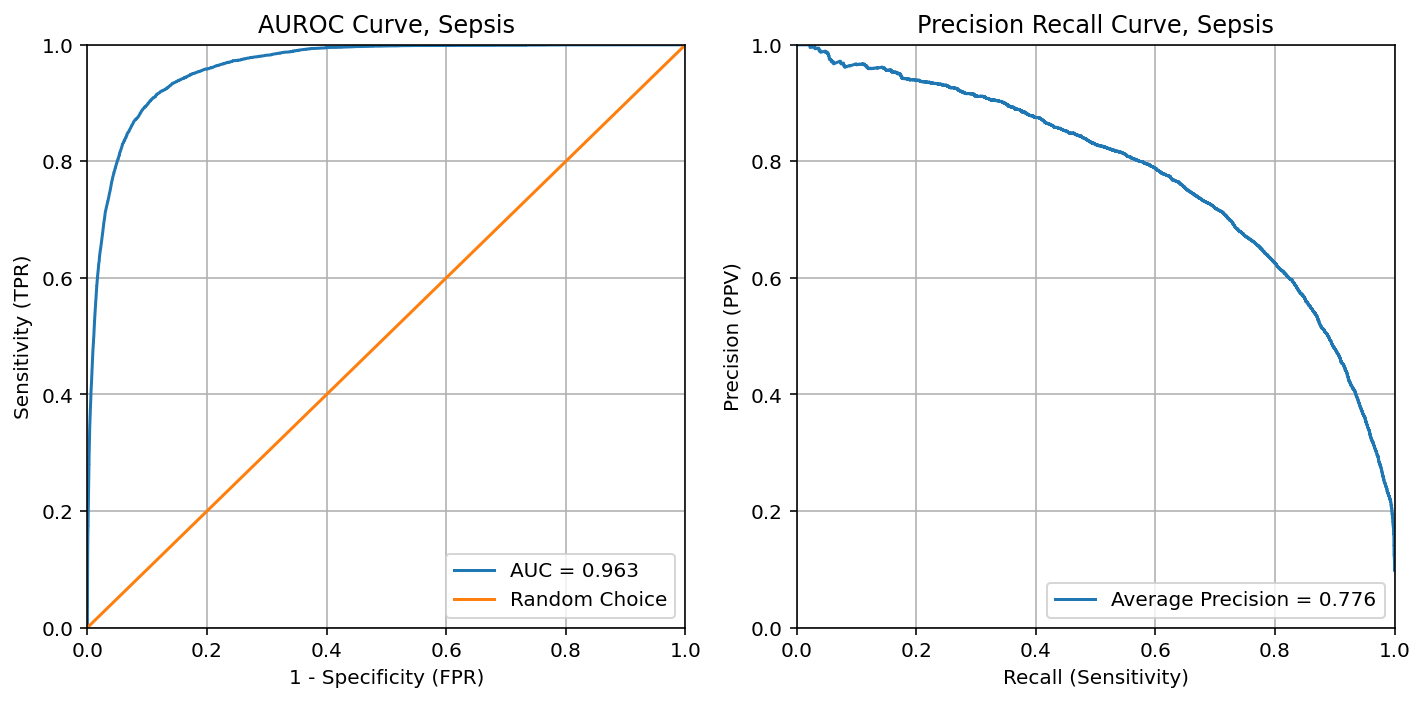

************************************************************
Total Time elapsed 5:31:31.864711
Process All Complete!


In [6]:
def train_test_split_fxn(main_df, id_sepsis, id_nosepsis, train_val_mrns, test_mrns, train_pc, test_pc, predefined_mrns):
    
    mrns = id_sepsis.tolist() + id_nosepsis.tolist()
    
    print(f'Splitting cohort into train and test set, train_pc: {train_pc*100}%; test_pc: {test_pc*100}%')
    main_df = main_df[[cols for cols in main_df.columns if not cols.startswith(('firstrace', 'Ethnicity', 'AdmissionInstant', 'SepsisTimeZero', 'SepsisLabel', 'abs_time'))]]
    main_df['ShiftedSepsisLabel'] = main_df['ShiftedSepsisLabel'].astype(int)
    
    if predefined_mrns:
        print('Splitting cohort into train/val and test set using predefined mrns..')
        train_val_mrns = train_val_mrns['Train_Val_mrns'].tolist()
        test_mrns = test_mrns['Test_mrns'].tolist()
    else:
        train_val_mrns, test_mrns = train_test_split(mrns, test_size=test_pc, random_state=1)
    
    train_val_df = main_df[main_df['ID'].isin(train_val_mrns)]
    test_df = main_df[main_df['ID'].isin(test_mrns)]    
    
    headers = main_df.drop(['ID', 'LOS', 'rel_time', 'ShiftedSepsisLabel'], axis = 1).columns.tolist()
    X_train = train_val_df.drop(['ID', 'LOS', 'rel_time', 'ShiftedSepsisLabel'], axis = 1).values
    X_test = test_df.drop(['ID', 'LOS', 'rel_time', 'ShiftedSepsisLabel'], axis = 1).values
    
    Y_train = train_val_df['ShiftedSepsisLabel'].values
    Y_test = test_df['ShiftedSepsisLabel'].values
    
    mrns_train = train_val_df['ID'].tolist()
    mrns_test = test_df['ID'].tolist()
    
    
    print((f"len(train_mrns): {len(train_val_mrns):,}"
           f"\nlen(test_mrns): {len(test_mrns):,}"
           f"\nX_train.shape: {X_train.shape}"
           f"\nX_test.shape: {X_test.shape}"
           f"\nY_train.shape: {Y_train.shape}"
           f"\nY_test.shape: {Y_test.shape}"))

    return X_train, X_test, Y_train, Y_test, mrns_train, mrns_test, headers

def train_classification_single(iteration, iters, X_train, X_val, Y_train, Y_val, X_test, Y_test):
    """
    This runs a single bootstrap.
    
    """
    
    auc_it = []
    acc_it = []
    f1_it = []
    mcc_it = []
    test_prob = {'XGBoost':[]}
    ft_imp = {'XGBoost':[]}
    clf_dict = {'XGBoost':[]}

    for clf in ['XGBoost']:
        results = '\nXGBoost Classifier {0:d}/{1:d}'.format(iteration, iters)
        modelname = clf
        
        from xgboost import XGBClassifier
        clf = XGBClassifier()
        clf.fit(X_train, Y_train)
        
        Y_train_pred = [clf.predict(X_train), clf.predict_proba(X_train)[:,1]]
        Y_val_pred = [clf.predict(X_val), clf.predict_proba(X_val)[:,1]]
        Y_test_pred = [clf.predict(X_test), clf.predict_proba(X_test)[:,1]]
        
        fpr, tpr, thresholds = roc_curve(Y_train, Y_train_pred[1])
        auc_train = auc(fpr, tpr)
        acc_train = accuracy_score(Y_train, Y_train_pred[0])
        f1_train = f1_score(Y_train, Y_train_pred[0])
        mcc_train = matthews_corrcoef(Y_train, Y_train_pred[0])
        results += '\nAUC Train: {0:4.3f}, Accuracy Train: {1:4.3f}, F1 Train: {2:4.3f}, MCC Train: {3:4.3f}'.format(auc_train, acc_train, f1_train, mcc_train)
       
        fpr, tpr, thresholds = roc_curve(Y_val, Y_val_pred[1])
        auc_val = auc(fpr, tpr)
        acc_val = accuracy_score(Y_val, Y_val_pred[0])
        f1_val = f1_score(Y_val, Y_val_pred[0])
        mcc_val = matthews_corrcoef(Y_val, Y_val_pred[0])
        results += '\nAUC Validation: {0:4.3f}, Accuracy Validation: {1:4.3f}, F1 Validation: {2:4.3f}, MCC Validation: {3:4.3f}'.format(auc_val, acc_val, f1_val, mcc_val)

        fpr, tpr, thresholds = roc_curve(Y_test, Y_test_pred[1])
        auc_test = auc(fpr, tpr)
        acc_test = accuracy_score(Y_test, Y_test_pred[0])
        f1_test = f1_score(Y_test, Y_test_pred[0])
        mcc_test = matthews_corrcoef(Y_test, Y_test_pred[0])
        results += '\nAUC Test: {0:4.3f}, Accuracy Test: {1:4.3f}, F1 Test: {2:4.3f}, MCC Test: {3:4.3f}'.format(auc_test, acc_test, f1_test, mcc_test)

        auc_it += [auc_train,auc_val,auc_test]
        acc_it += [acc_train,acc_val,acc_test]
        f1_it += [f1_train,f1_val,f1_test]
        mcc_it += [mcc_train,mcc_val,mcc_test]
       
        print(results)
       
        ft_imp['XGBoost'] = clf.feature_importances_
        test_prob['XGBoost'] = Y_test_pred[1]
        clf_dict['XGBoost'] = clf
         
    return iteration, auc_it, acc_it, f1_it, mcc_it, test_prob, ft_imp, clf_dict, clf

def save_data(X_train, Y_train, X_test, Y_test, mrns_train, mrns_test, ft_imp, results, clf, timestr, save_path):
    print('---'*20)
    print('Saving all Data')
    print('---'*20)
    
    print(f'Saving all important data into: \n {save_path}')
    
    foldername_data = 'train_test_split'
    full_path_data = os.path.join(save_path, foldername_data) 
    if not os.path.isdir(full_path_data):
        os.mkdir(full_path_data)
    train_val_filename = os.path.join(full_path_data, f'train_val_set_{timestr}')
    np.savez(train_val_filename, x=X_train, y=Y_train)
    print(f'Saved train/val set data as:\n {train_val_filename}.npz')
    test_filename = os.path.join(full_path_data, f'test_set_{timestr}')
    np.savez(test_filename, x=X_test, y=Y_test)
    print(f'Saved test set data as:\n {test_filename}.npz')
    
    foldername_mrns = 'train_test_split_mrns'
    full_path_mrns = os.path.join(save_path, foldername_mrns) 
    if not os.path.isdir(full_path_mrns):
        os.mkdir(full_path_mrns)
    train_val_mrns_filename = os.path.join(full_path_mrns, f'train_val_set_mrns_{timestr}.csv')
    train_val_mrns_df = pd.DataFrame({'Train_Val_mrns':mrns_train})
    train_val_mrns_df.to_csv(train_val_mrns_filename, index=False)
    print(f'Saved train/val set mrns as:\n {train_val_mrns_filename}')
    test_mrns_filename = os.path.join(full_path_mrns, f'test_set_mrns_{timestr}.csv')
    test_mrns_df = pd.DataFrame({'Test_mrns':mrns_test})
    test_mrns_df.to_csv(test_mrns_filename, index=False)
    print(f'Saved test set mrns as:\n {test_mrns_filename}')
    
    foldername_ft_imp = 'feature_importance'
    full_path_ft_imp = os.path.join(save_path, foldername_ft_imp) 
    if not os.path.isdir(full_path_ft_imp):
        os.mkdir(full_path_ft_imp)
    ft_imp_filename = os.path.join(full_path_ft_imp, f'feature_importance_{timestr}.csv')
    ft_imp.to_csv(ft_imp_filename, index=False)
    print(f'Saved feature importance as:\n {ft_imp_filename}')
    
    foldername_model_results = 'model_results'
    full_path_model_results = os.path.join(save_path, foldername_model_results) 
    if not os.path.isdir(full_path_model_results):
        os.mkdir(full_path_model_results)
    model_results_filename = os.path.join(full_path_model_results, f'model_results_{timestr}.csv')
    results.to_csv(model_results_filename, index=False)
    print(f'Saved model results as:\n {model_results_filename}')
    
    foldername_model = 'model'
    full_path_model = os.path.join(save_path, foldername_model) 
    if not os.path.isdir(full_path_model):
        os.mkdir(full_path_model)
    model_filename = os.path.join(full_path_model, f'xgboost_model_{timestr}')
    with open(f'{model_filename}.pkl', 'wb') as fh:
        pickle.dump(clf, fh)
    print(f'Saved model as:\n {model_filename}.pkl')
    
def plot_auc_pr_curve(X_test, Y_test, clf, timestr, outcome, save_path):
    print('---'*20)
    print(f'Plotting AUROC and AUPRC plots and Saving Threshold Metrics')
    print('---'*20)
    
    ytestpred = clf.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(Y_test, ytestpred)
    operating_Thresholds = []
    operating_levels = [0, 0.0001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99, 0.999, 1]
    ix_level = 0
    
    for ix, thr in enumerate(thresholds):
        if fpr[ix] >= operating_levels[ix_level]:
            operating_Thresholds.append(thr)
            ix_level += 1
            if ix_level == len(operating_levels):
                break
    
    operating_Thresholds = np.array(thresholds)
    N = operating_Thresholds.reshape(-1,1).shape[0]
    TP = np.zeros(N)
    TN = np.zeros(N)
    FN = np.zeros(N)
    FP = np.zeros(N)
    sens = np.zeros(N)
    spec = np.zeros(N)
    ppv = np.zeros(N)
    acc = np.zeros(N)
    f1 = np.zeros(N)
    mcc = np.zeros(N)
    
    results_ix = {'threshold':0,'tp':1,'tn':2,'fn':3,'fp':4, 'ppv':5,'sensitivity':6,'specificity':7,'accuracy':8,'f1':9,'mcc':10}
    report_metrics = 'Test set metrics:\n'
    threshold_metrics = []
    
    for ix,t in enumerate(operating_Thresholds):
        TP[ix] = tp = ((Y_test > 0) & (ytestpred.ravel() > t)).sum()*1.0
        TN[ix] = tn = ((Y_test == 0) & (ytestpred.ravel() <= t)).sum()*1.0
        FN[ix] = fn = ((Y_test > 0) & (ytestpred.ravel() <= t)).sum()*1.0
        FP[ix] = fp = ((Y_test == 0) & (ytestpred.ravel() > t)).sum()*1.0
    
        denom = (tp + fn)
        sens[ix] = tp / denom if denom != 0 else 0.0
        denom = (tn + fp)
        spec[ix] = tn / denom if denom != 0 else 0.0
        denom = (tp + fp)
        ppv[ix] = tp / denom if denom != 0 else 0.0
        denom = (tp + tn + fp + fn)
        acc[ix] = (tp + tn) / denom if denom != 0 else 0.0
        denom = (2*tp + fp + fn)
        f1[ix] = 2*tp / denom if denom != 0 else 0.0
        denom = np.sqrt((tp+fp)*(tp+fn)*(tn*fp)*(tn*fp))
        mcc[ix] = ((tp * tn) - (fp * fn)) / denom if denom != 0 else 0.0
        report_metrics += '@threshold:{0:4.3f}, sens:{1:4.3f}, spec:{2:4.3f}, ppv:{3:4.3f}, acc:{4:4.3f}, f1:{5:4.3f}, mcc:{6:4.3f}, total+:{7:,d}, total-:{8:,d}\n'.format(t, sens[ix], spec[ix], ppv[ix], acc[ix], f1[ix], mcc[ix], int(tp+fp), int(tn+fn))
        threshold_metrics.append([t, sens[ix], spec[ix], ppv[ix], acc[ix], f1[ix], mcc[ix], int(tp+fp), int(tn+fn)])
    
    threshold_metrics_df_cols = ['Threshold', 'Sensitivity', 'Specificity', 'PPV', 'Accuracy', 'F1', 
                                 'MCC', 'Total_Positive', 'Total_Negative']
    threshold_metrics_df = pd.DataFrame(threshold_metrics, columns=threshold_metrics_df_cols)
    foldername_threshold_results = 'threshold_metrics'
    full_path_threshold_results = os.path.join(save_path, foldername_threshold_results) 
    if not os.path.isdir(full_path_threshold_results):
        os.mkdir(full_path_threshold_results)
    threshold_metrics_filename = os.path.join(full_path_threshold_results, f'threshold_metrics_{timestr}.csv')
    threshold_metrics_df.to_csv(threshold_metrics_filename, index=False)
    print(f'Saved threshold metrics as:\n {threshold_metrics_filename}')
    
    results_arr = np.hstack((operating_Thresholds.reshape(-1,1),TP.reshape(-1,1),TN.reshape(-1,1),FN.reshape(-1,1),FP.reshape(-1,1),ppv.reshape(-1,1),sens.reshape(-1,1),spec.reshape(-1,1),acc.reshape(-1,1),f1.reshape(-1,1),mcc.reshape(-1,1),(TP+FP).reshape(-1,1),(TN+FN).reshape(-1,1)))
    test_auc = auc(fpr, tpr)
    test_avg_prec = average_precision_score(Y_test, ytestpred)
    
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    ax1.set_title(f'AUROC Curve, {outcome}')
    ax1.set_xlabel('1 - Specificity (FPR)')
    ax1.set_ylabel('Sensitivity (TPR)')
    ax1.set_xlim(0,1)
    ax1.set_ylim(0,1)
    
    ax2.set_title(f'Precision Recall Curve, {outcome}')
    ax2.set_xlabel('Recall (Sensitivity)')
    ax2.set_ylabel('Precision (PPV)')
    ax2.set_xlim(0,1)
    ax2.set_ylim(0,1)
    
    ax1.plot(1 - spec, sens, label=f'AUC = {test_auc:.3f}')
    ax1.plot([0,1], [0,1], label='Random Choice')
    
    precision, recall, _ = precision_recall_curve(Y_test, ytestpred)
    ax2.plot(recall, precision, label=f'Average Precision = {test_avg_prec:.3f}')
    
    ax1.grid()
    ax1.legend()
    ax2.grid()
    ax2.legend(loc='lower right')
    
    plt.tight_layout()   
    foldername_plots = 'plots'
    full_path_plots = os.path.join(save_path, foldername_plots) 
    if not os.path.isdir(full_path_plots):
        os.mkdir(full_path_plots)
    plot_filename = os.path.join(full_path_plots, f'auc_prc_plot_{timestr}.png')
    plt.savefig(plot_filename, bbox_inches='tight', dpi=1000)
    print(f'Saved plot as:\n {plot_filename}')
    plt.show()
        
def run_bootstrap(X_train, Y_train, X_test, Y_test, headers, mrns_train, mrns_test, n_iters, outcome, save_path):
    print('---'*20)
    print(f'Model is Training for {n_iters} Bootstraps to Predict {outcome}')
    print('---'*20)
    
    Y_train, Y_test = np.asarray(Y_train), np.asarray(Y_test)
    X_train_orig, Y_train_orig = X_train, Y_train
    N = X_train.shape[0]
    N_subset = int(N*0.9)
    ix_list = np.arange(N)
    iters = n_iters
    res_cols = ['XGBoost_Train','XGBoost_Val','XGBoost_Test']
    auc_cols = [c+'_AUC' for c in res_cols]
    auc_arr = np.zeros((iters,len(res_cols)), dtype=float)
    acc_cols = [c+'_ACC' for c in res_cols]
    acc_arr = np.zeros((iters,len(res_cols)), dtype=float)
    f1_cols = [c+'_F1' for c in res_cols]
    f1_arr = np.zeros((iters,len(res_cols)), dtype=float)
    mcc_cols = [c+'_MCC' for c in res_cols]
    mcc_arr = np.zeros((iters,len(res_cols)), dtype=float)
    test_prob = {'XGBoost': np.zeros((iters, Y_test.shape[0]))}
    ft_imp = {'XGBoost': np.zeros((iters, len(headers)))}
    clf_dict = {'XGBoost':list(np.zeros(iters))}
    
    for iteration in range(0, iters):
        random.shuffle(ix_list)
        X_train_split, X_val, Y_train_split, Y_val = train_test_split(X_train_orig[ix_list[:N_subset],:], Y_train_orig[ix_list[:N_subset]], test_size=0.3)
        run, auc_it, acc_it, f1_it, mcc_it, tp, fi, cd, clf = train_classification_single(iteration, iters, X_train_split, X_val, Y_train_split, Y_val, X_test, Y_test)
        auc_arr[run] = auc_it
        acc_arr[run] = acc_it
        f1_arr[run] = f1_it
        mcc_arr[run] = mcc_it
        test_prob['XGBoost'][run] = tp['XGBoost']
        ft_imp['XGBoost'][run] = fi['XGBoost']
        clf_dict['XGBoost'][run] = cd['XGBoost']
        
    auc_mean = auc_arr.mean(axis=0)
    auc_mean_ste = (1.96/np.sqrt(iters)) * auc_arr.std(axis=0)
    acc_mean = acc_arr.mean(axis=0)
    acc_mean_ste = (1.96/np.sqrt(iters)) * acc_arr.std(axis=0)
    f1_mean = f1_arr.mean(axis=0)
    f1_mean_ste = (1.96/np.sqrt(iters)) * f1_arr.std(axis=0)
    mcc_mean = mcc_arr.mean(axis=0)
    mcc_mean_ste = (1.96/np.sqrt(iters)) * mcc_arr.std(axis=0)
    
    results = pd.DataFrame(np.hstack((np.array(res_cols).reshape(-1,1), 
                        auc_mean.reshape(-1,1), 
                        auc_mean_ste.reshape(-1,1),
                        acc_mean.reshape(-1,1),
                        acc_mean_ste.reshape(-1,1),
                        f1_mean.reshape(-1,1),
                        f1_mean_ste.reshape(-1,1),
                        mcc_mean.reshape(-1,1),
                        mcc_mean_ste.reshape(-1,1)
                       )), 
             columns = ['Model', 'AUC Mean', 'AUC Mean STE', 'ACC Mean', 'ACC Mean STE', 'F1 Mean', 'F1 Mean STE', 'MCC Mean', 'MCC Mean STE']
            )
    
    ft_imp_mean = [np.mean(ft_imp[k], axis=0).reshape(-1,1) for k in ft_imp]
    ft_imp_mean = pd.DataFrame(np.hstack((np.array(headers).reshape(-1,1), ft_imp_mean[0])), columns=['features', 'XGBoost'])
    for col in ft_imp_mean.columns:
        if col=='features':
            continue
        else:
            ft_imp_mean[col] = ft_imp_mean[col].astype(float)
            ft_imp_mean[col+'_abs'] = np.abs(ft_imp_mean[col])
    ft_imp_mean.sort_values(by='XGBoost_abs', ascending=False, inplace=True)

    mcc_arg_max = mcc_arr[:,res_cols.index('XGBoost_Val')].argmax()
    clf = clf_dict['XGBoost'][mcc_arg_max]
    
    timestr = time.strftime("%Y%m%d_%H%M%S")
    save_data(X_train_orig, Y_train_orig, X_test, Y_test, mrns_train, mrns_test, ft_imp_mean, results, clf, timestr, save_path)
    plot_auc_pr_curve(X_test, Y_test, clf, timestr, outcome, save_path)
    
    return results, clf, timestr
    
if __name__ == '__main__':
    start = datetime.now()
    print('---'*20)
    print('Basic Cohort Information')
    print('---'*20)
    X_train, X_test, Y_train, Y_test, mrns_train, mrns_test, headers = train_test_split_fxn(main_df, id_sepsis, id_nosepsis, train_val_mrns, test_mrns, train_pc, test_pc, predefined_mrns)
    print(f'Shape of train/val set combined: {X_train.shape}; shape of test set {X_test.shape}')
    print(f'There are {np.unique(Y_train, return_counts=True)[1][1]} {outcome} labels and {np.unique(Y_train, return_counts=True)[1][0]} no {outcome} labels in the train/val set')
    print(f'There are {np.unique(Y_test, return_counts=True)[1][1]} {outcome} labels and {np.unique(Y_test, return_counts=True)[1][0]} no {outcome} labels and in the test set')
    results, clf, timestr = run_bootstrap(X_train, Y_train, X_test, Y_test, headers, mrns_train, mrns_test, n_iters, outcome, save_path)
    end_time = datetime.now()
    print('***'*20)
    print('Total Time elapsed {}'.format(end_time - start))
    print('Process All Complete!')

### Test Set Results

In [ ]:
# Use this function to replace/ablate lactate-related columns with np.nan
def ablate_lactate(X_test, headers):
    temp_df = pd.DataFrame(X_test, columns=headers)
    lactate_cols = [header for header in headers if header.lower().startswith('lactate')]
    for cols in lactate_cols:
        temp_df[cols] = np.nan
    
    return temp_df.values

X_test_ablated = ablate_lactate(X_test, headers)

In [8]:
test_scores_df = pd.DataFrame(mrns_test, columns=['ID'])
test_scores_df['LOS'] = main_df[main_df['ID'].isin(mrns_test)]['LOS'].tolist()
test_scores_df['PredictedProbability'] = clf.predict_proba(X_test)[:,1]
test_scores_df['PredictedProbabilityAblated'] = clf.predict_proba(X_test_ablated)[:,1]
test_scores_df['SepsisTrueLabel'] = Y_test.tolist()
test_scores_df = test_scores_df.merge(sepsis_label_df, on=['ID'], how='left')
test_scores_df.iloc[:,1:].head()

,LOS,PredictedProbability,SepsisTrueLabel,t_timezero
0,0,0.0093,0,NaN
1,3,0.0058,0,NaN
2,6,0.0055,0,NaN
3,9,0.0047,0,NaN
4,12,0.0063,0,NaN


In [9]:
thresholds = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.09, 0.10, 0.15, 0.20, 0.25, 0.3, 0.4,0.5]
for threshold in thresholds:
    test_scores_df[f'SepsisLabel_{threshold}'] = [0 if score <= threshold else 1 for score in test_scores_df['PredictedProbability']]
    test_scores_df[f'SepsisLabel_{threshold}Ablated'] = [0 if score <= threshold else 1 for score in test_scores_df['PredictedProbabilityAblated']]
test_scores_df.to_csv(f'/gpfs/data/paulab/sepsis_floor_prediction/sepsis_real_time_prediction/model_results/test_set_results_{timestr}.csv', index=False)

### Plot feature importance

In [11]:
ft_imp = pd.read_csv(f'/gpfs/data/paulab/sepsis_floor_prediction/sepsis_real_time_prediction/feature_importance/feature_importance_{timestr}.csv', usecols=['features', 'XGBoost']).iloc[:20, :]
ft_imp.sort_values(by=['XGBoost'], ascending=True, inplace=True)

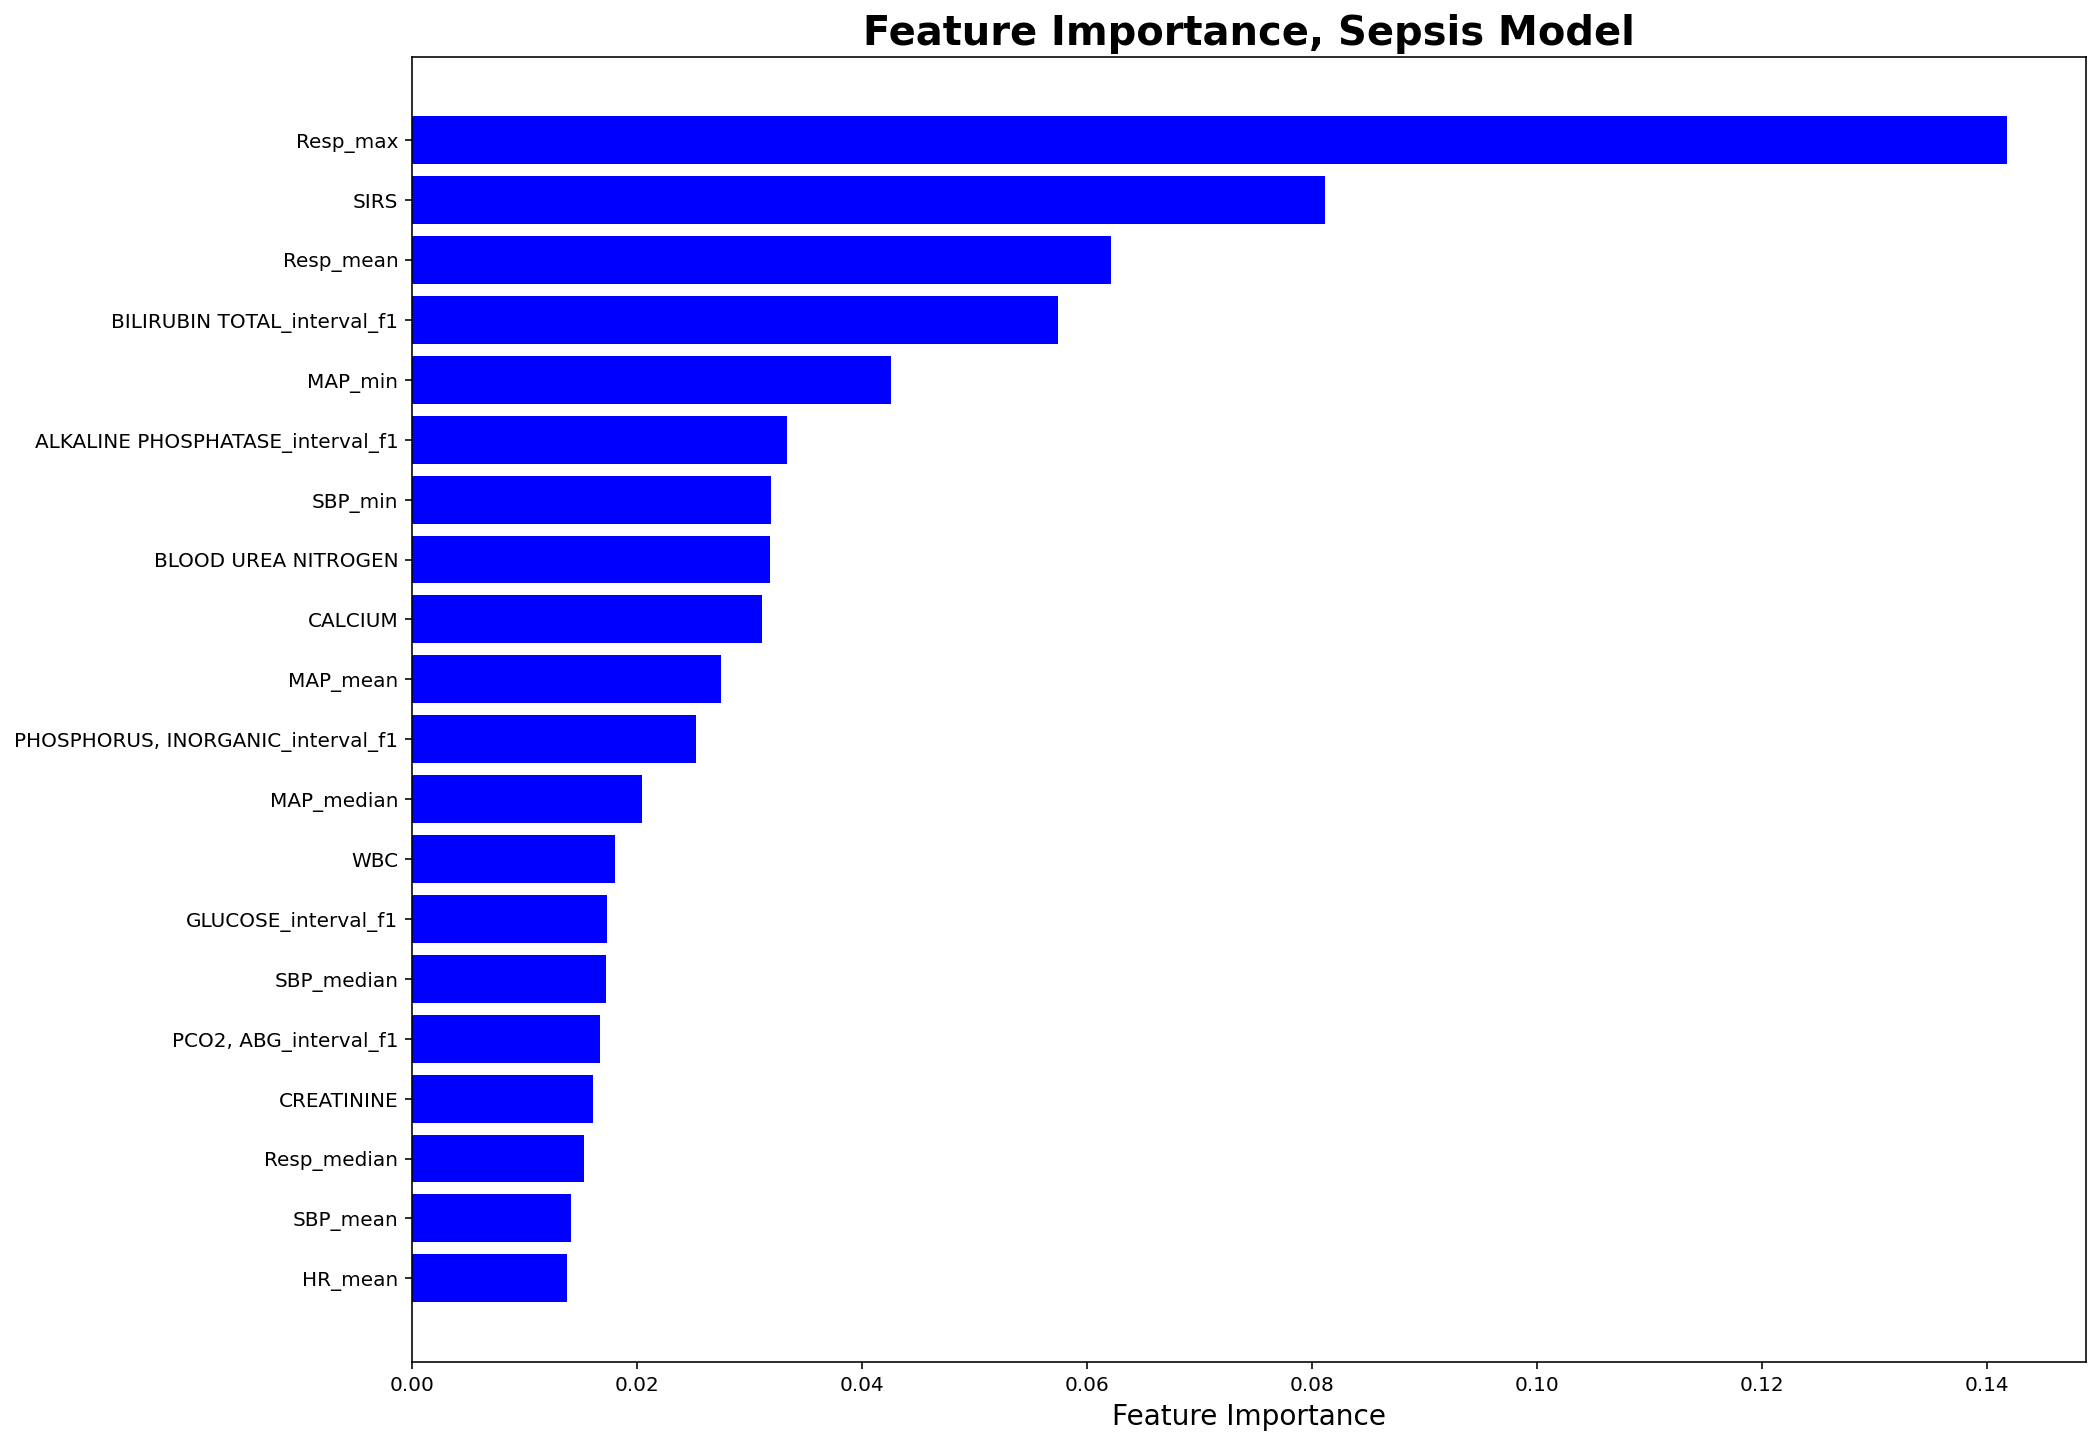

In [12]:
plt.figure(figsize=(15, 12))
plt.barh(ft_imp.features, ft_imp.XGBoost, color='b')
plt.title('Feature Importance, Sepsis Model', fontweight="bold", size=20), plt.xlabel('Feature Importance', size=14)
plt.show()